# 펀드 위험등급 산출

## 패키지 로드

In [1]:
%matplotlib inline

In [2]:
import functools
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import trange

In [3]:
plt.rc('font', family='Malgun Gothic')  # For Windows

## 변수 정의

In [4]:
TEST_PROCESS = eval(os.environ.get('TEST_PROCESS', 'True'))
VALIDATE_PROCESS = eval(os.environ.get('VALIDATE_PROCESS', 'True'))
DATA_FILEPATH = os.environ.get('DATA_FILEPATH', './data/TYPE_10_채권형.csv')
BINS = eval(os.environ.get('BINS', '[0, 0.005, 0.05, 0.10, 0.15, 0.25, float("inf")]'))

print(f'{TEST_PROCESS=}, {VALIDATE_PROCESS=}, {DATA_FILEPATH=}, {BINS=}')

TEST_PROCESS=False, VALIDATE_PROCESS=False, DATA_FILEPATH='data\\TYPE_11_MMF.csv', BINS=[0, 0.005, 0.05, 0.1, 0.15, 0.25, inf]


## 타입 추출

In [5]:
filepath = Path(DATA_FILEPATH)
filename_pattern = re.compile(r'TYPE_([0-9]+)_([^_]+)\.csv')

match_rst = re.fullmatch(filename_pattern, filepath.name)
type_no, type_name = match_rst.groups()

type_no, type_name

('11', 'MMF')

## 데이터 로드

In [6]:
lists_wo_idx_df = pd.read_csv(filepath, names=["date", "code", "nav"], usecols=[0, 1, 2], parse_dates=[0])
lists_df = lists_wo_idx_df.set_index(['code', 'date'])

codes = lists_df.index.get_level_values('code').unique()
print(f"{len(codes)=}")

len(codes)=448


## 수치 산출 테스트

1년을 기준으로 프로세스 정의

### 기간 조건 적용

In [7]:
if TEST_PROCESS:
    lists_1y_df = pd.concat([
        lists_df.xs(code).last('1y').assign(code=code)
        for code in codes])
    lists_1y_df.reset_index(inplace=True)
    display(lists_1y_df)

### 리샘플링, 퍼센트 체인지 추출

In [8]:
if TEST_PROCESS:
    lists_1y_wk_df = lists_1y_df.set_index(['date']).groupby(['code'])[['nav']].resample('W').last()
    lists_1y_wk_df = lists_1y_wk_df.assign(ret=lists_1y_wk_df.groupby(['code'])[['nav']].pct_change())
    display(lists_1y_wk_df)

### 표준편차 산출

In [9]:
if TEST_PROCESS:
    lists_1y_std_df = lists_1y_wk_df.groupby(['code'])[['ret']].std(numeric_only=True) * np.sqrt(52)
    lists_1y_std_df.reset_index(inplace=True)
    lists_1y_std_df.rename(columns={'ret': 'std_1y'}, inplace=True)
    display(lists_1y_std_df)

### VaR 산출

In [10]:
if TEST_PROCESS:
    lists_1y_var_df = lists_1y_wk_df.groupby(['code'])[['ret']].quantile(0.025, numeric_only=True)
    lists_1y_var_df = np.minimum(lists_1y_var_df, 0) * -1 * np.sqrt(52)
    lists_1y_var_df.rename(columns={'ret': 'var_1y'}, inplace=True)
    display(lists_1y_var_df)

## 수치 산출 프로세스 정의

In [11]:
offsets = ['1y', '3y']

In [12]:
%%time

lists_rst_dfs = []

for offset in offsets:
    lists_off_df = pd.concat([
        lists_df.xs(code).last(offset).assign(code=code)
        for code in codes])
    lists_off_df.reset_index(inplace=True)

    lists_off_wk_df = lists_off_df.set_index(['date']).groupby(['code'])[['nav']].resample('W').last()
    lists_off_wk_df = lists_off_wk_df.assign(ret=lists_off_wk_df.groupby(['code'])[['nav']].pct_change())

    lists_off_std_df = lists_off_wk_df.groupby(['code'])[['ret']].std(numeric_only=True) * np.sqrt(52)
    lists_off_std_df.rename(columns={'ret': f'std_{offset}'}, inplace=True)

    lists_off_var_df = lists_off_wk_df.groupby(['code'])[['ret']].quantile(0.025, numeric_only=True)
    lists_off_var_df = np.minimum(lists_off_var_df, 0) * -1 * np.sqrt(52)
    lists_off_var_df.rename(columns={'ret': f'var_{offset}'}, inplace=True)

    lists_rst_dfs.append(lists_off_std_df)
    lists_rst_dfs.append(lists_off_var_df)

lists_rst_df = pd.concat(lists_rst_dfs, axis='columns')
lists_rst_df

CPU times: total: 2.94 s
Wall time: 2.98 s


,std_1y,var_1y,std_3y,var_3y
code,,,,
K55101B72028,0.000891,-0.0,0.013378,-0.0
K55101B72036,0.000892,-0.0,0.013655,-0.0
K55101BC8873,0.009169,-0.0,0.011201,-0.0
K55101BJ6490,0.000913,-0.0,0.006172,-0.0
K55101BJ6508,0.000912,-0.0,0.006663,-0.0
...,...,...,...,...
KR5373144900,0.015841,-0.0,0.014545,-0.0
KR5373144918,0.011635,-0.0,0.010680,-0.0
KR5373144926,0.000238,-0.0,0.000238,-0.0


### 프로세스 테스트

In [13]:
%%time

def calc_std_y(code):
    df = lists_wo_idx_df[lists_wo_idx_df['code'] == code][["date", "nav"]]
    df = df.sort_values(by="date")
    df = df.set_index("date")

    df_1y = df.last("1Y")
    df_1y_w = df_1y.resample("W").last()

    df_3y = df.last("3Y")
    df_3y_w = df_3y.resample("W").last()

    df_3y_w["ret"] = df_3y_w["nav"].pct_change()
    df_3y_w = df_3y_w.iloc[1:]
    std_3y = df_3y_w["ret"].std() * np.sqrt(52)

    df_1y_w["ret"] = df_1y_w["nav"].pct_change()
    df_1y_w = df_1y_w.iloc[1:]
    std_1y = df_1y_w["ret"].std() * np.sqrt(52)

    var_3y = -np.minimum(df_3y_w["ret"].quantile(0.025), 0) * np.sqrt(52)

    return std_3y, std_1y, var_3y

if VALIDATE_PROCESS:
    list_std_y = []
    for i in trange(len(codes)):
        code = codes[i]
        list_std_y.append(calc_std_y(code))

CPU times: total: 0 ns
Wall time: 0 ns


In [14]:
if VALIDATE_PROCESS:
    for code_idx, code in enumerate(codes):
        for old_idx, new_name in [(0, 'std_3y'), (1, 'std_1y'), (2, 'var_3y')]:
            old_rst = list_std_y[code_idx][old_idx]
            new_rst = lists_rst_df.xs(code).xs(new_name)
            if not np.isclose(old_rst, new_rst, equal_nan=True):
                print(f"{code=}, {old_rst=}, {new_rst=}, {np.isclose(old_rst, new_rst, equal_nan=True)=}")

## 등급 변환

In [15]:
labels = ["6등급", "5등급", "4등급", "3등급", "2등급", "1등급"]
cut_fn = functools.partial(pd.cut, bins=BINS, labels=labels)

lists_lb_df = lists_rst_df.assign(
    risk_std_1y=cut_fn(lists_rst_df['std_1y']),
    risk_std_3y=cut_fn(lists_rst_df['std_3y']),
    # risk_var_1y=cut_fn(lists_rst_df['var_1y']),
    risk_var_3y=cut_fn(lists_rst_df['var_3y']))
lists_lb_df.dropna(inplace=True)
lists_lb_df.reset_index(inplace=True)

lists_lb_df

,code,std_1y,var_1y,std_3y,var_3y,risk_std_1y,risk_std_3y,risk_var_3y
0,K55101BV3509,0.052295,-0.000000,0.043111,0.000436,4등급,5등급,6등급
1,K55101CM2634,0.004937,0.012365,0.004937,0.012365,6등급,6등급,5등급
2,K55102D80629,0.002997,-0.000000,0.005254,0.001584,6등급,5등급,6등급
3,K55105CF3330,0.009849,0.012680,0.009849,0.012680,5등급,5등급,5등급
4,K55105CF8214,0.002938,0.006265,0.002658,0.008639,6등급,6등급,5등급
5,K55107DA3977,0.001216,0.001845,0.001216,0.001845,6등급,6등급,6등급
6,K55107DM9780,0.009135,0.014043,0.009135,0.014043,5등급,5등급,5등급
7,K55205BU9031,0.007790,0.014428,0.007790,0.014428,5등급,5등급,5등급
8,K55207CR6096,0.019024,-0.000000,0.012462,0.001801,5등급,5등급,6등급
9,K55214D20537,0.003545,0.007976,0.006978,0.012470,6등급,5등급,5등급


#### 프로세스 테스트

In [16]:
if VALIDATE_PROCESS:
    list_std_3y, list_std_1y, list_var_3y = zip(*list_std_y)

    df_result = pd.DataFrame({
        "code": codes,
        "std_3y": list_std_3y,
        "std_1y": list_std_1y,
        "var_3y": list_var_3y,
    })

    bins = [0, 0.005, 0.05, 0.10, 0.15, 0.25, float("inf")]
    labels = ["6등급", "5등급", "4등급", "3등급", "2등급", "1등급"]

    df_result["risk_std_3y"] = pd.cut(df_result.std_3y, bins=bins, labels=labels)
    df_result["risk_std_1y"] = pd.cut(df_result.std_1y, bins=bins, labels=labels)
    df_result["risk_var_3y"] = pd.cut(df_result.var_3y, bins=bins, labels=labels)

    df_result = df_result.dropna()

In [17]:
if VALIDATE_PROCESS:
    display(
        (lists_lb_df[['code', 'risk_std_1y', 'risk_std_3y', 'risk_var_3y']].set_index(['code'])
        == df_result[['code', 'risk_std_1y', 'risk_std_3y', 'risk_var_3y']].set_index(['code'])).all())

## 등급 결과 출력

In [18]:
os.makedirs('result', exist_ok=True)
lists_lb_df.to_csv(f'result/RESULT_{type_no}_{type_name}.csv', index=False)

## 시각화

In [19]:
risk_std_3y_stat_df = lists_lb_df["risk_std_3y"].value_counts().sort_index(ascending=False)
risk_std_1y_stat_df = lists_lb_df["risk_std_1y"].value_counts().sort_index(ascending=False)
risk_var_3y_stat_df = lists_lb_df["risk_var_3y"].value_counts().sort_index(ascending=False)
stat_df = pd.concat([risk_std_3y_stat_df, risk_std_1y_stat_df, risk_var_3y_stat_df], axis=1)
stat_df = stat_df.rename(columns={"risk_std_3y": "3년 표준편차", "risk_std_1y": "1년 표준편차", "risk_var_3y": "3년 VaR"})
stat_df.reset_index(names=['등급'], inplace=True)

stat_df.set_index('등급').style.background_gradient()

,3년 표준편차,1년 표준편차,3년 VaR
등급,,,
1등급,0,0,0
2등급,0,0,4
3등급,0,1,1
4등급,5,5,1
5등급,27,21,14
6등급,6,11,18


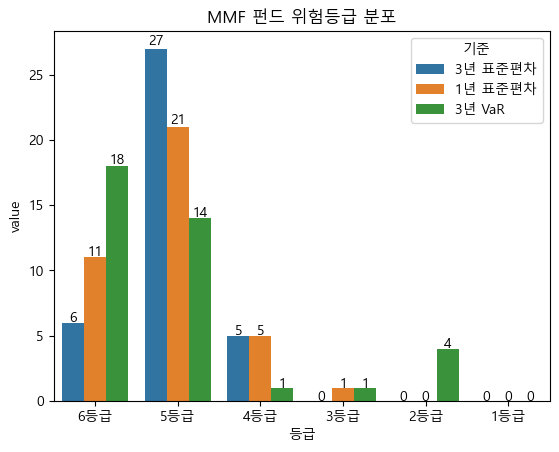

In [20]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height() * 0.01)
                value = '{:d}'.format(int(p.get_height()))
                ax.text(_x, _y, value, ha="center")
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height() * 0.5)
                value = '{:d}'.format(int(p.get_width()))
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)


stat_df_long = (
    stat_df
    .melt(id_vars="등급", value_vars=["3년 표준편차", "1년 표준편차", "3년 VaR"], var_name="기준") \
    .rename(columns={"index": "등급"})
)
axis = sns.barplot(x="등급", y="value", hue="기준", data=stat_df_long)
axis.set_title(f"{type_name} 펀드 위험등급 분포")
show_values(axis)

## 통계 결과 출력

In [21]:
os.makedirs('result', exist_ok=True)
stat_df.to_csv(f'result/STATISTICS_{type_no}_{type_name}.csv', index=False)